AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [1]:
# 📦 1. Importar librerías
import pandas as pd

In [3]:
# 💬 Instalar AutoGluon si es necesario
#%pip install autogluon.timeseries

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

c:\Users\leona\anaconda3\envs\py310lab3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../data/sell-in.txt", sep="\t")
df_productos = pd.read_csv("../data/tb_productos.txt", sep="\t")

In [5]:
# 📄 Leer lista de productos a predecir
with open("../data/product_id_apredecir201912.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

In [6]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')

In [7]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]

In [8]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()

In [9]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()

In [10]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']

In [11]:
# ⏰ 4. Crear TimeSeriesDataFrame
ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp'
)

In [12]:
# Completar valores faltantes
ts_data = ts_data.fill_missing_values()

In [13]:
# ⚙️ 5. Definir y entrenar predictor
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS'  # Frecuencia mensual (Month Start), 
)

predictor.fit(ts_data, num_val_windows=2, time_limit=60*60)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250703_012458'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       7.65 GB / 31.71 GB (24.1%)
Disk Space Avail:   181.70 GB / 952.62 GB (19.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided t

In [14]:
# 🔮 6. Generar predicción
forecast = predictor.predict(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [18]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.185099,-0.172091,13.042073,6.136370,2.193378,13
1,ChronosFineTuned[bolt_small],-0.185593,-0.178941,1.471147,0.777895,509.543792,8
2,TemporalFusionTransformer,-0.190028,-0.184278,0.533387,0.466135,283.010763,9
3,TiDE,-0.193636,-0.228854,0.683419,0.583403,368.772888,12
4,DeepAR,-0.206369,-0.185993,0.850189,0.600729,142.150416,10
5,PatchTST,-0.209386,-0.186348,0.324043,0.266944,65.956461,11
6,ChronosZeroShot[bolt_base],-0.211922,-0.190460,6.767752,3.958645,140.191317,7
7,AutoETS,-0.215147,-0.201045,4.865196,3.222628,3.269042,6
8,DynamicOptimizedTheta,-0.221798,-0.203868,0.581083,0.664996,3.087361,5
9,DirectTabular,-0.231603,-0.243576,0.212374,0.109094,17.501044,3


data with frequency 'IRREG' has been resampled to frequency 'MS'.


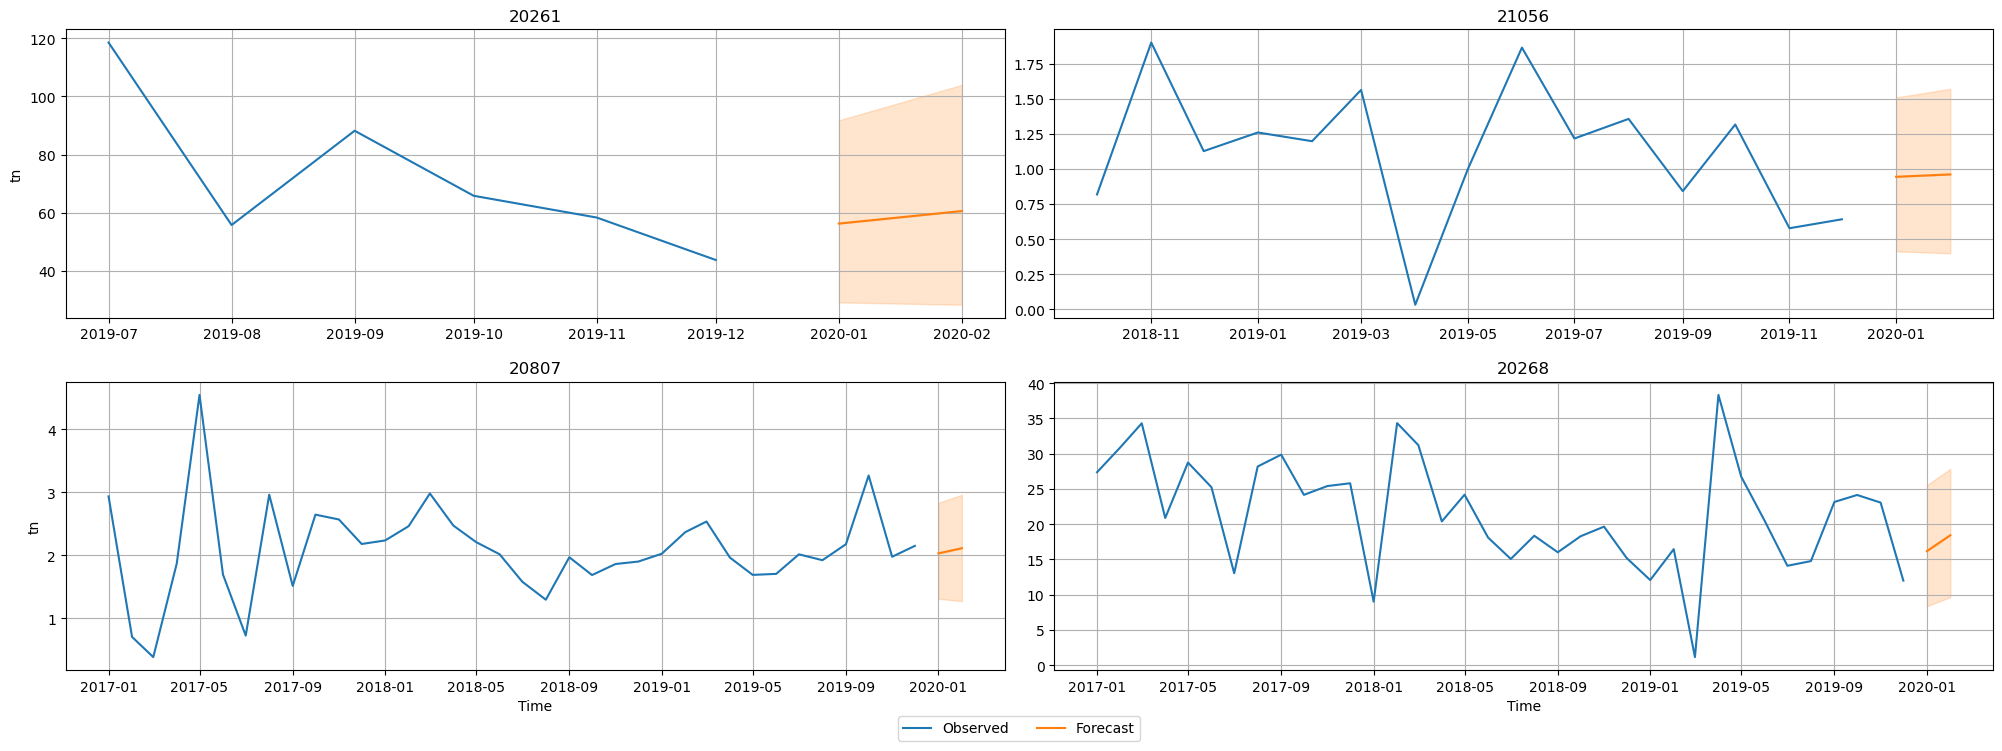

In [ ]:
predictor.plot(ts_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [15]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [16]:
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [ ]:
# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_v1.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1303.226827
3,20002,1066.312475
5,20003,700.919699
7,20004,522.597608
9,20005,512.527806


In [ ]:
from autogluon.common import space

# ⚙️ 5. Definir y entrenar predictor
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    eval_metric="MASE",
    freq='MS'  # Frecuencia mensual (Month Start), 
)

predictor.fit(
    ts_data,
    presets="best_quality",    
    hyperparameters={
        "DeepAR": {
            "hidden_size": space.Int(20, 100),
            "dropout_rate": space.Categorical(0.1, 0.3),
        },
        "Theta": [
            {"decomposition_type": "additive"},
            {"seasonal_period": 1},
        ],
        "Chronos": [
            {
                "model_path": "bolt_small", 
                "ag_args": {"name_suffix": "ZeroShot"}
            },
            {
                "model_path": "bolt_small", 
                "fine_tune": True, 
                "ag_args": {"name_suffix": "FineTuned"}
            },
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },            
        ]        
    },
    enable_ensemble=True,
    time_limit=3600
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250703_023005'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.57 GB / 31.71 GB (27.0%)
Disk Space Avail:   176.32 GB / 952.62 GB (18.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {},
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_m

In [21]:
forecast2 = predictor.predict(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [26]:
forecast2

mean          0.1          0.2          0.3  \
item_id timestamp                                                        
20001   2020-01-01  1347.863213  1021.785472  1147.674925  1209.981602   
        2020-02-01  1402.976851  1102.936151  1206.591152  1291.129653   
20002   2020-01-01  1155.045858   838.241336   950.292629  1016.401014   
        2020-02-01  1134.621410   872.204324   976.103826  1036.359135   
20003   2020-01-01   782.555714   558.353048   627.441784   675.661001   
...                         ...          ...          ...          ...   
20995   2020-02-01     2.194541     0.388509     1.066127     1.474239   
21087   2020-01-01     0.776542     0.242059     0.443533     0.587355   
        2020-02-01     0.788834     0.154546     0.377598     0.532756   
21214   2020-01-01     0.215819    -0.137318    -0.013266     0.079333   
        2020-02-01     0.217886    -0.217182    -0.054002     0.049390   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
20001   2020-01-01  1276.360329  1347.863213  1411.289550  1475.049801   
        2020-02-01  1354.266687  1402.976851  1472.413004  1553.272405   
20002   2020-01-01  1092.601022  1155.045858  1213.807856  1276.885286   
        2020-02-01  1088.141099  1134.621410  1189.426372  1236.668214   
20003   2020-01-01   735.473673   782.555714   832.601757   885.698130   
...                         ...          ...          ...          ...   
20995   2020-02-01     1.865576     2.194541     2.567090     2.907617   
21087   2020-01-01     0.697404     0.776542     0.890103     1.012694   
        2020-02-01     0.663390     0.788834     0.897450     1.030089   
21214   2020-01-01     0.148540     0.215819     0.287278     0.354092   
        2020-02-01     0.136654     0.217886     0.302018     0.390170   

                            0.8          0.9  
item_id timestamp                             
20001   2020-01-01  1569.045446  1677.688563  
        2020-02-01  1628.387750  1744.427691  
20002   2020-01-01  1354.270297  1462.592035  
        2020-02-01  1291.588464  1383.217083  
20003   2020-01-01   945.567246  1067.669212  
...                         ...          ...  
20995   2020-02-01     3.350733     4.219058  
21087   2020-01-01     1.135869     1.352220  
        2020-02-01     1.205715     1.442619  
21214   2020-01-01     0.434627     0.562562  
        2020-02-01     0.502169     0.655243  

[1560 rows x 10 columns]

In [23]:
forecast_mean2 = forecast2['mean'].reset_index()
print(forecast_mean2.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [24]:
# Tomar solo item_id y la predicción 'mean'
resultado2 = forecast2['mean'].reset_index()[['item_id', 'mean']]
resultado2.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado2 = forecast2['mean'].reset_index()
resultado2 = resultado2[resultado2['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado2 = resultado2[['item_id', 'mean']]
resultado2.columns = ['product_id', 'tn']

In [25]:
resultado2.to_csv("../data/autogluon_202002_v2.csv", index=False)
resultado2.head()

,product_id,tn
1,20001,1402.976851
3,20002,1134.621410
5,20003,809.182062
7,20004,616.419363
9,20005,658.942611
